<h1><center>Pharmaceutical-Sales-prediction </center></h1>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import dvc.api
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import mlflow
# To ignore any warnings
import warnings                        
warnings.filterwarnings("ignore")
import os
import logging


In [3]:
#Load training data 
path = 'data/train.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'train_v1'
data_url2 = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
train_data=pd.read_csv(data_url2)
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
#load test data
path = 'data/test.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'test_v1'
data_url3 = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
test_data=pd.read_csv(data_url3)
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
#load store data
path = 'data/store.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'store_v1'
data_url = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
store_data=pd.read_csv(data_url)
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


#### Glance the data

In [6]:
print("shape of the  store data: ",store_data.shape)
print(store_data.info())

shape of the  store data:  (1115, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


In [7]:
print("shape of the  train data: ",train_data.shape)
print(train_data.nunique())

shape of the  train data:  (1017209, 9)
Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         5
SchoolHoliday        2
dtype: int64


### Data cleaning

In [8]:
#data extraction
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day
train_data['WeekOfYear'] = train_data['Date'].dt.weekofyear
#Coping dataframe for later plots
train_data_copy=train_data.copy() #for later plots


In [9]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31


In [10]:
#checking for missing values in training data
train_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
Year             0
Month            0
Day              0
WeekOfYear       0
dtype: int64


- As shown above the training data has no missing values.

In [11]:
#checking for missing values in test data
test_data.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64


-  The test data has a missing value for open variable , we impute it using the mode.

In [12]:
# impute the missing value in test data
test_data['Open'].fillna(test_data['Open'].mode, inplace = True)
test_data.isnull().values.any()

False

In [13]:
# closed stores
train_data[(train_data.Open == 0) & (train_data.Sales == 0)].count()

Store            172817
DayOfWeek        172817
Date             172817
Sales            172817
Customers        172817
Open             172817
Promo            172817
StateHoliday     172817
SchoolHoliday    172817
Year             172817
Month            172817
Day              172817
WeekOfYear       172817
dtype: int64

In [14]:
print(train_data.shape)
closed_stores = train_data[(train_data['Open'] == 0) & (train_data['Sales'] == 0)].index
#To avoid any biased forecasts we will drop these values.
train_data.drop(closed_stores,inplace = True)
print(train_data.shape)


(1017209, 13)
(844392, 13)


In [15]:
open_no_sale = train_data[(train_data["Open"] != 0) & (train_data['Sales'] == 0)].index
train_data[(train_data["Open"] != 0) & (train_data['Sales'] == 0)]['Date'].nunique()

49

- There are open stores with no sales.We can presume that external variables played a role. There're only 49 days in the data.

In [16]:
train_data.drop(open_no_sale,inplace = True)
train_data.shape

(844338, 13)

In [19]:
# Stores with maximum sale count
train_data.groupby('Store')['Sales','Customers'].sum().sort_values('Sales', ascending=False).head()

,Sales,Customers
Store,,
262,19516842,3204694
817,17057867,2454370
562,16927322,2924960
1114,16202585,2509542
251,14896870,1908934


In [20]:
store_exc = train_data[(train_data["StateHoliday"] != "o") & (train_data["Sales"] != 0)]["Store"].nunique()
print(f"There are {store_exc} stores that have opened during state holidays.")

There are 1115 stores that have opened during state holidays.


In [21]:
#check for missing values in store dataframe
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

- We need to deal with a couple of variables that have missing values.

In [22]:
#fill missing values in CompetitionDistance with median value
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(), inplace = True)

In [23]:
#fill missing values with mode
store_data['CompetitionOpenSinceMonth'].fillna(store_data['CompetitionOpenSinceMonth'].mode, inplace = True)
store_data['CompetitionOpenSinceYear'].fillna(store_data['CompetitionOpenSinceYear'].mode, inplace = True)
store_data['Promo2SinceWeek'].fillna(store_data['Promo2SinceWeek'].mode, inplace = True)
store_data['Promo2SinceYear'].fillna(store_data['Promo2SinceYear'].mode, inplace = True)
store_data['PromoInterval'].fillna(store_data['PromoInterval'].mode, inplace = True)
store_data.isnull().values.any()

False

- Let us take a closer look at the various StoreType levels and how the main metric Sales is distributed among them.

In [24]:
print("Joining train set with an additional store information.")
train_store = train_data.merge(store_data,on=["Store"],how="inner")


Joining train set with an additional store information.


In [25]:
train_store.shape

(844338, 22)

In [26]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


- Among all StoreTypes, StoreType B has the greatest average of Sales, although we have significantly less data for it.StoreType D has the least average of Sales.

In [27]:
#overall sum of Sales and Customers to see which StoreType is the most selling and crowded one
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


 - StoreType A is the most selling and crowded one.

## Correlation matrix

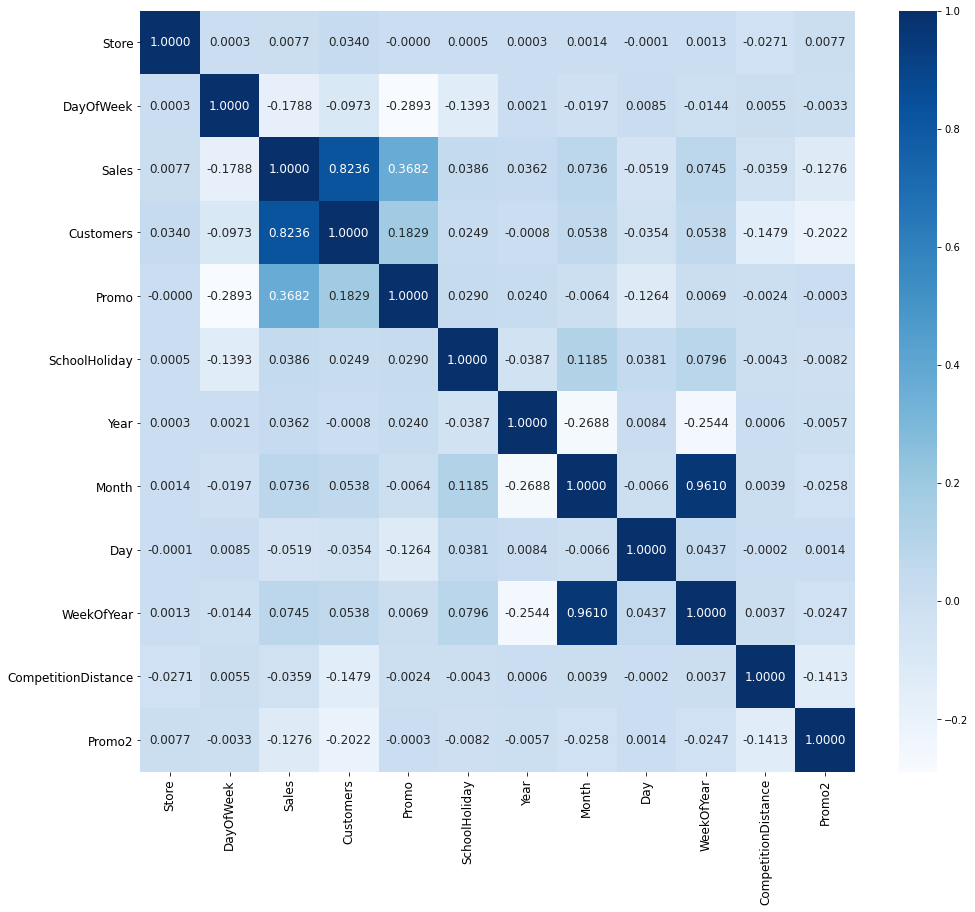

In [28]:

corrMatrix= train_store.drop('Open', axis = 1).corr()
f, ax = plt.subplots(figsize=(16, 14))
res=sns.heatmap(corrMatrix,cmap="Blues",annot=True,fmt='.4f',annot_kws={"size":12})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)
plt.show()

- As shown in the figure, the dark Blue squares represents more closely correlated data. **sales and customers data are highly correlated**.

Text(0.5, 1.0, 'Monthly Sales data\n')

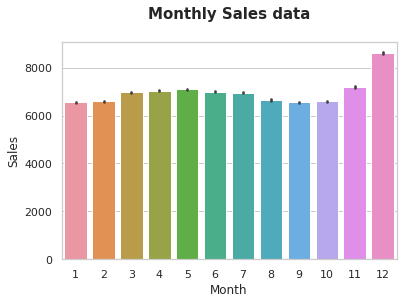

In [29]:
sns.set(style="whitegrid")
ax = sns.barplot(x="Month", y="Sales", data=train_store)
plt.title('Monthly Sales data\n', size=15, fontweight='bold')

In [30]:
#check seasonality for the given store
def seasonality(store):
    sales = train_data[train_data.Store == store]
    sales = sales.sort_values(by = "Date",ascending= False)
    sns.set(rc = {'figure.figsize':(20,8)})
    sns.lineplot(x = sales["Date"], y = sales["Sales"], color= "green")
    plt.xticks(rotation=90)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Sales', fontsize=16)
    plt.title(f'Seasonality of store {store}\n', size=20, fontweight='bold')
    plt.show()

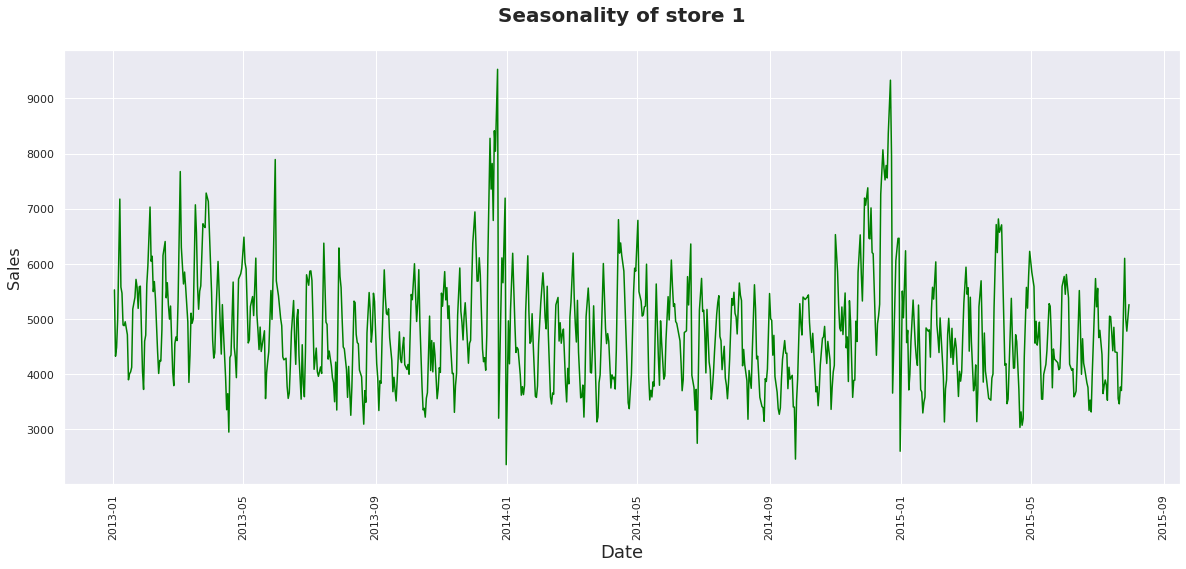

In [31]:
seasonality(1)

In [32]:
#check seasonality for 2013,2014 and 2015 for a given store
def seasonality_year(store):
    sale = train_data[train_data.Store == store]
    sale = sale[(sale.Year == 2015) | (sale.Year == 2014) | (sale.Year == 2013)]
    sale = sale.sort_values(by = "Date",ascending= False)
    sns.set(rc = {'figure.figsize':(20,8)})
    sns.lineplot(x = sale["Date"], y = sale["Sales"], color= "green")
    plt.xticks(rotation=90)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Sales', fontsize=16)
    plt.title(f'Seasonality of store {store} from 2013-2015 \n', size=20, fontweight='bold')
    plt.show()

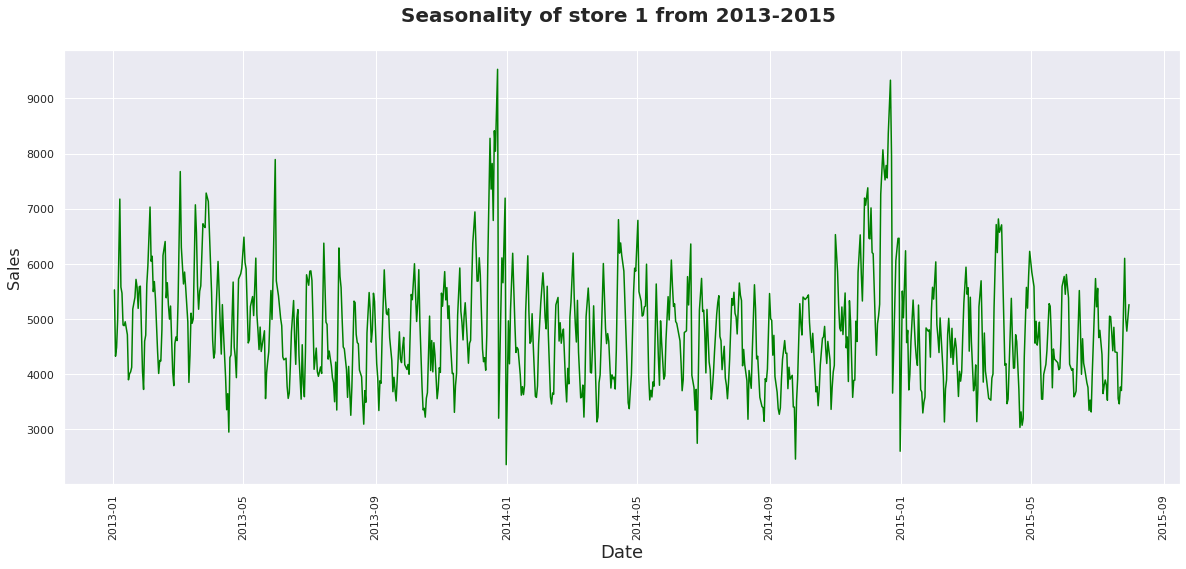

In [33]:
seasonality_year(1)

In [34]:
def plot_counts(df:pd.DataFrame, column1:str) -> None:
    plt.figure(figsize=(4, 2))
    sns.countplot(data=df, x=column1)
    plt.title(f'Distribution of {column1}\n', size=13, fontweight='bold')
    plt.show()

In [35]:
promo = pd.DataFrame()
promo['train promo'] = train_data['Promo']
promo['test promo'] = test_data['Promo']



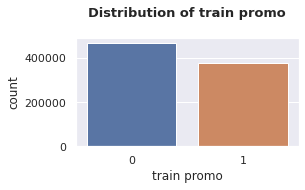

In [36]:
#distribution of train promo
plot_counts(promo, 'train promo')


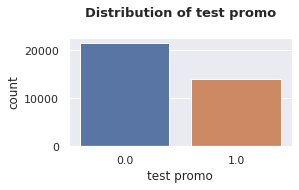

In [37]:
#distribution of test promo
plot_counts(promo, 'test promo')

In [38]:
#sales behavior before, during and after holidays
pre_holiday = train_data[(train_data["Date"]> '2013-12-09') & (train_data["Date"]< '2013-12-22')  ]

during_holiday=train_data[(train_data["Date"]> '2013-12-22') & (train_data["Date"]< '2013-12-31')  ]

post_holiday = train_data[(train_data["Date"]> '2013-12-31') & (train_data["Date"]< '2014-01-15')  ]

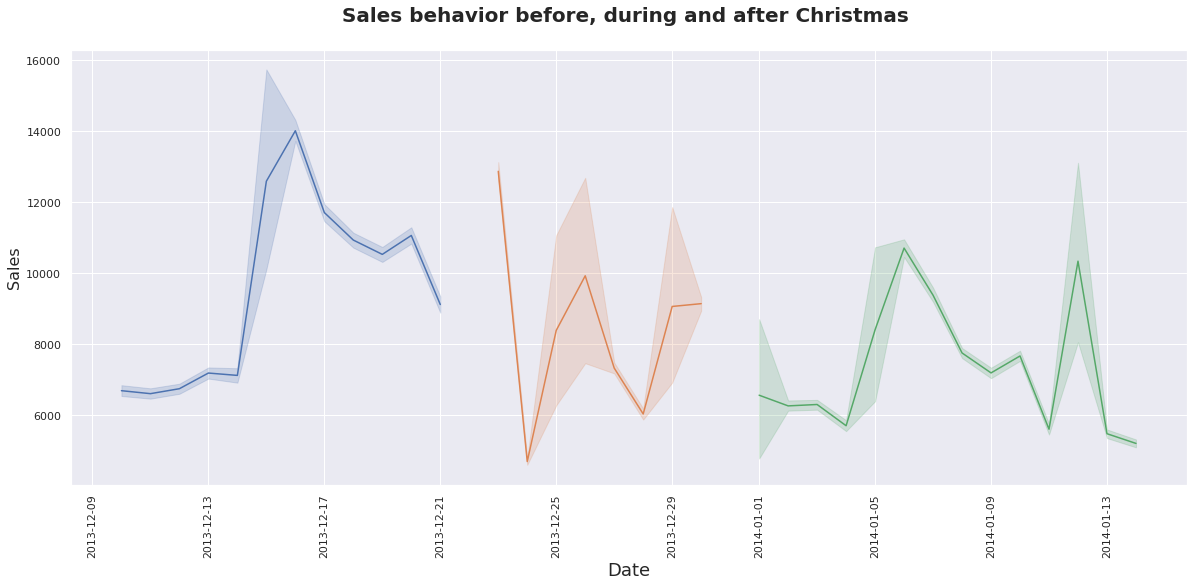

In [39]:
sns.lineplot(x = pre_holiday["Date"] , y = pre_holiday["Sales"] )
sns.lineplot(x = during_holiday["Date"] , y = during_holiday["Sales"] )
sns.lineplot(x = post_holiday["Date"] , y = post_holiday["Sales"] )
plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.title(f'Sales behavior before, during and after Christmas \n', size=20, fontweight='bold')
plt.show()

- As demonstrated in the figure, purchases prior to the holiday are large, while purchases during the holiday are relatively low.

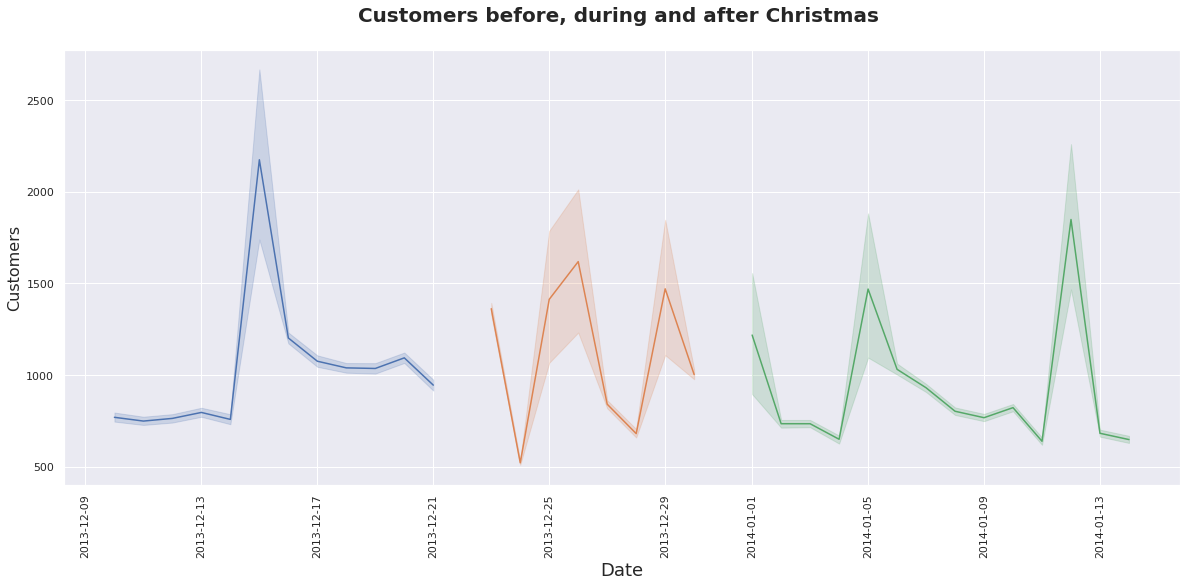

In [40]:
#Customers before, during and after Christmas
sns.lineplot(x = pre_holiday["Date"] , y = pre_holiday["Customers"] )
sns.lineplot(x = during_holiday["Date"] , y = during_holiday["Customers"] )
sns.lineplot(x = post_holiday["Date"] , y = post_holiday["Customers"] )
plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Customers', fontsize=16)
plt.title(f'Customers before, during and after Christmas \n', size=20, fontweight='bold')
plt.show()

### Trends of customer behavior during store open and closing times


Text(0.5, 1.0, 'Customers behavior during store open and closing times \n\n ')

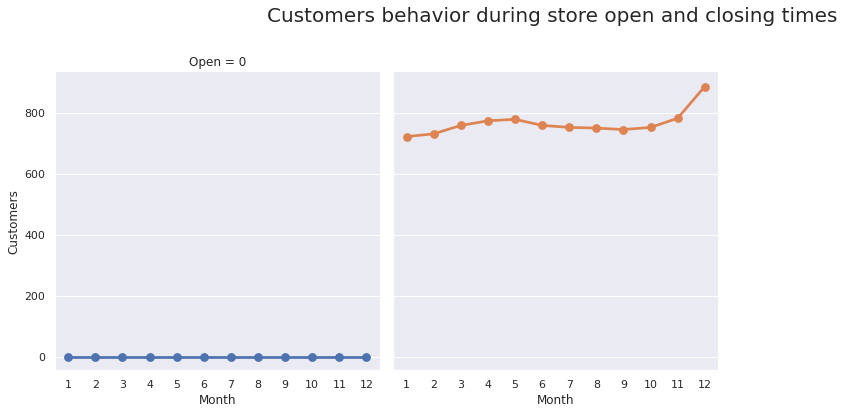

In [41]:
sns.factorplot(data = train_data_copy, x = 'Month', hue = 'Open',
               y = "Customers", 
               col = 'Open')
 
plt.title(f'Customers behavior during store open and closing times \n\n ', size=20)       

#### Which stores are opened on all weekdays?

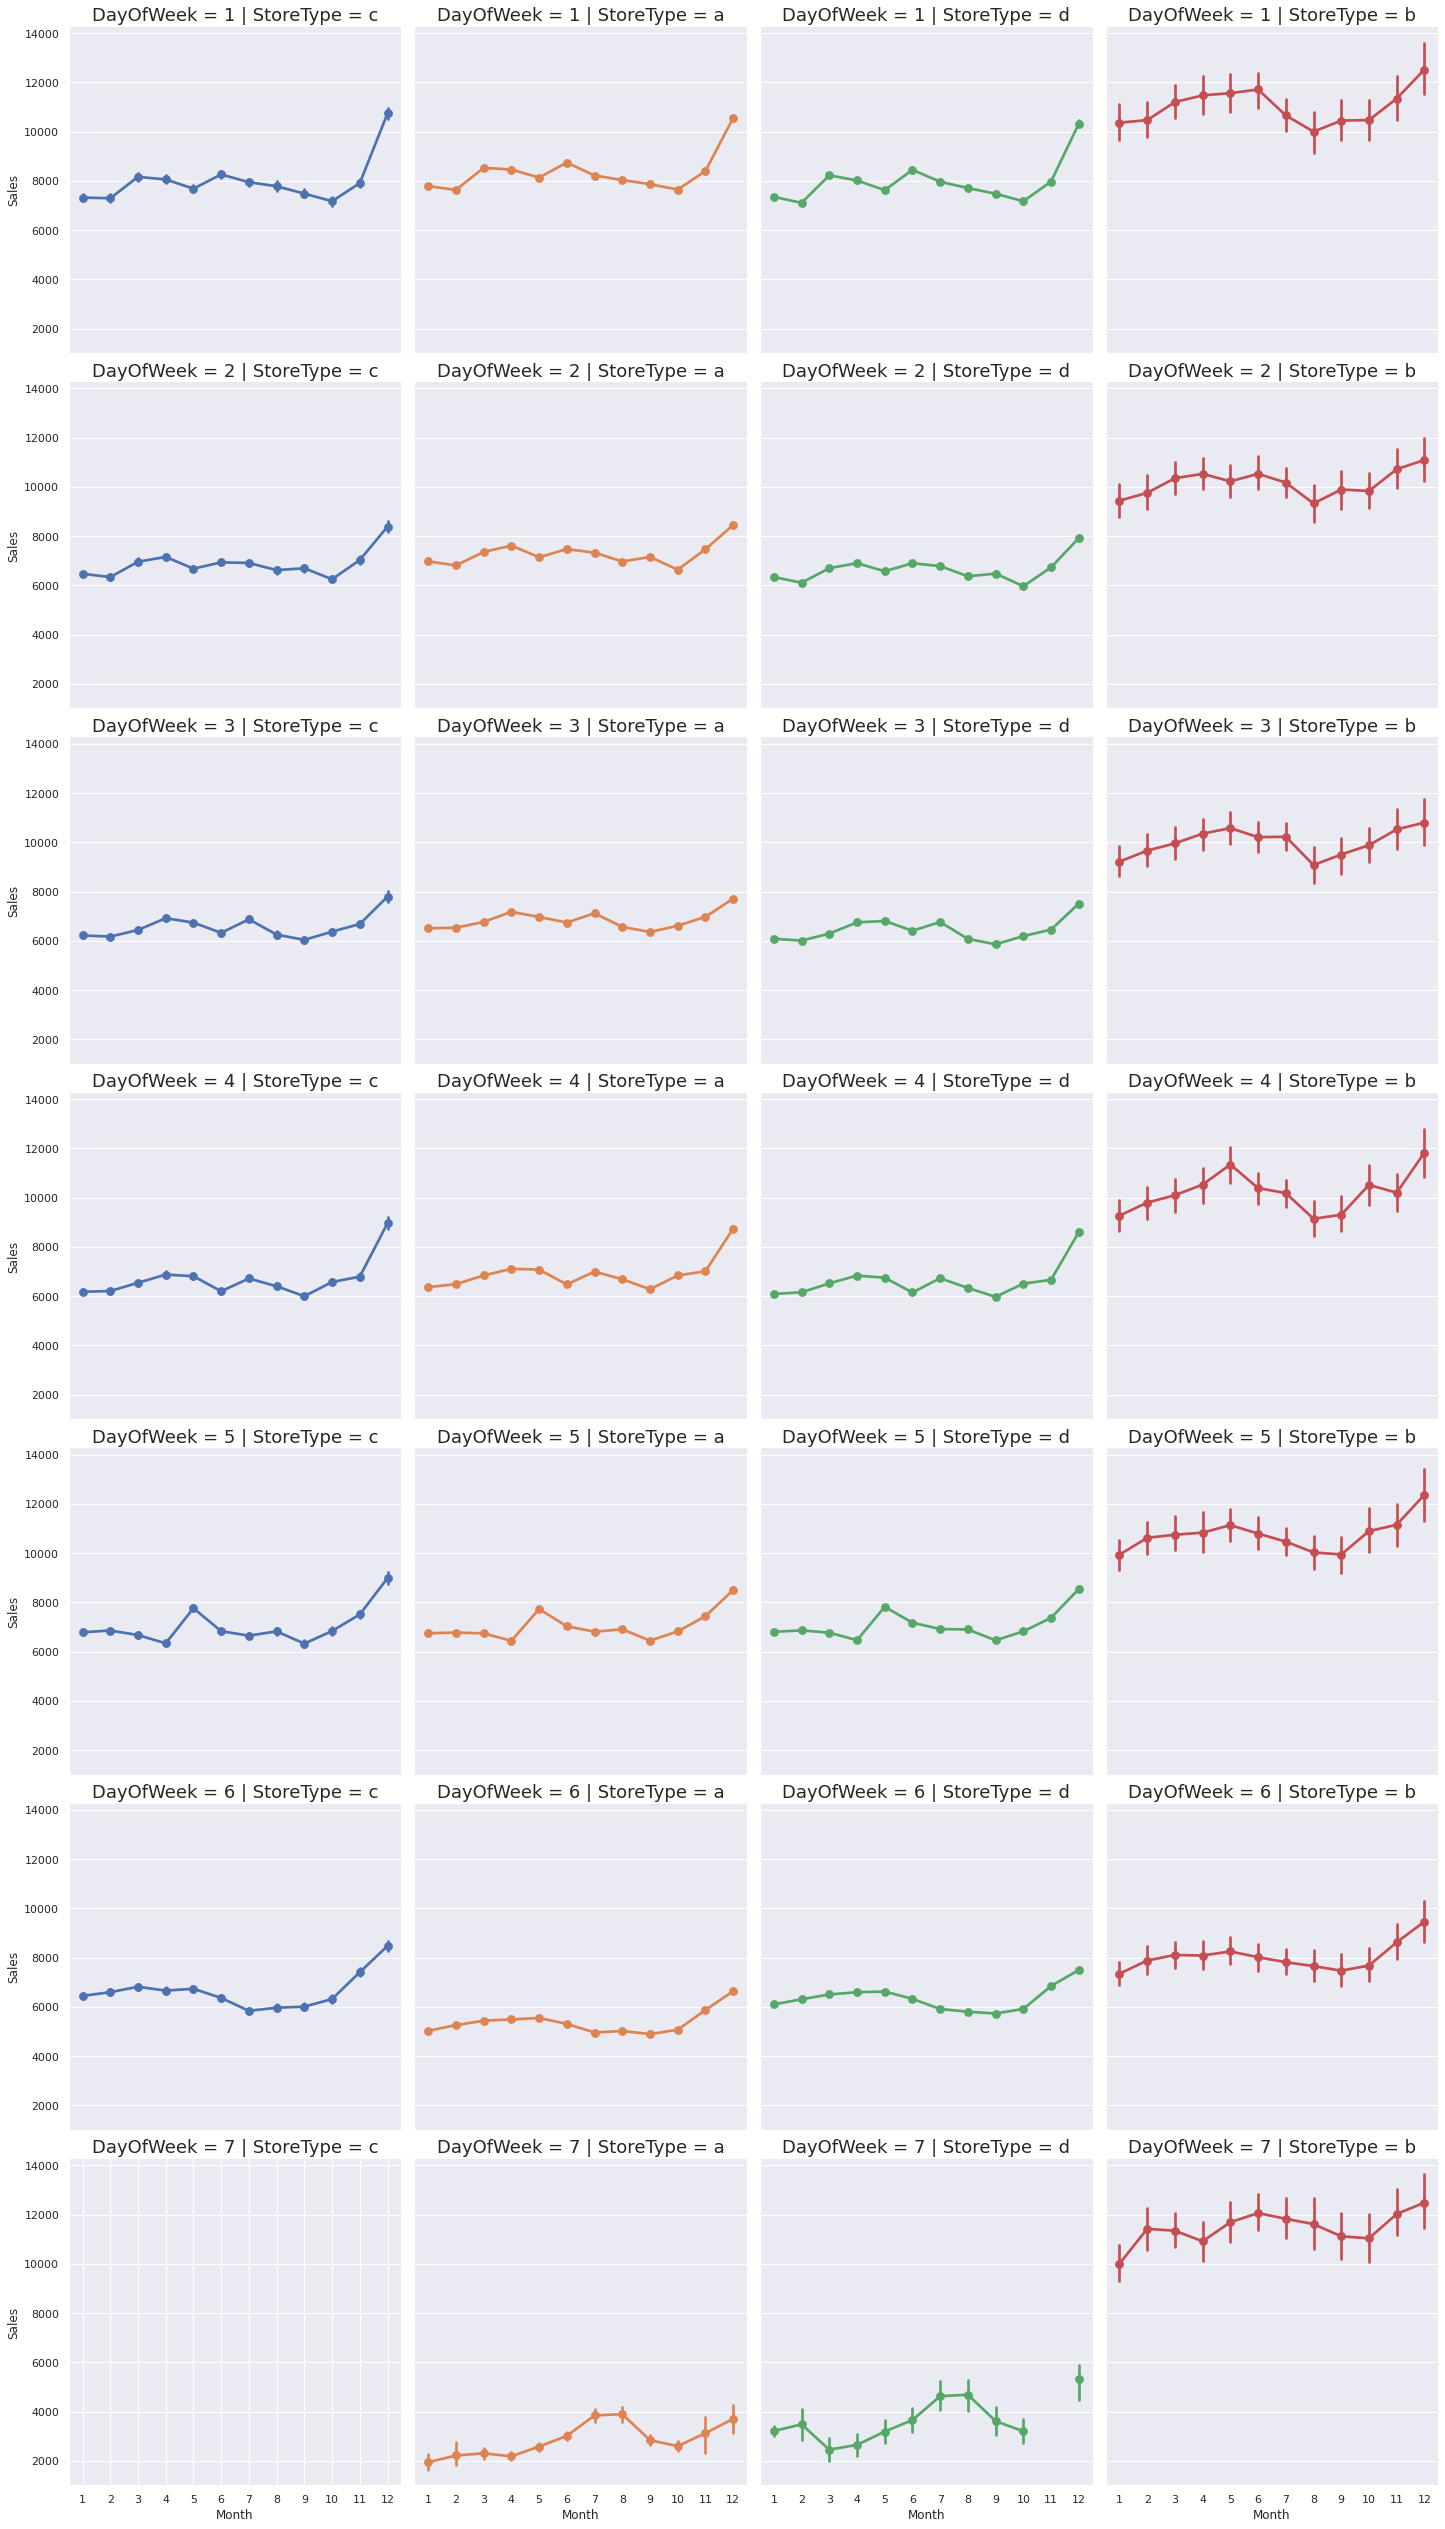

In [58]:
#customers trends
g=sns.factorplot(data = train_store, x = 'Month', y = "Sales", hue = 'StoreType',
               col = 'StoreType', # per store type in cols
               row = 'DayOfWeek', # per day of week in the stores
               ) 
g.set_titles(size=18)


- We can see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened.StoreType D stores are only closed on Sundays from October to December.

#### Effect of Assorment type on sales

Text(0.5, 1.0, 'Effect of Assorment type on sales\n\n ')

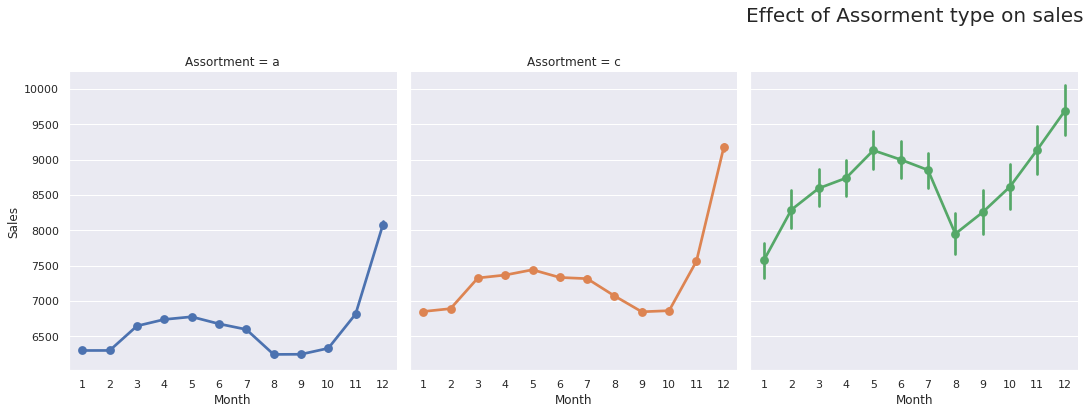

In [55]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales",hue = 'Assortment',
               col = 'Assortment') 
plt.title("Effect of Assorment type on sales\n\n ", size=20)

- Assortment type b has significant sales volume, and  the trend that assortment b use is better than others.

#### Effect of promotion on sales and number of customers

Text(0.5, 1.0, 'Effect of promotion on sales\n\n ')

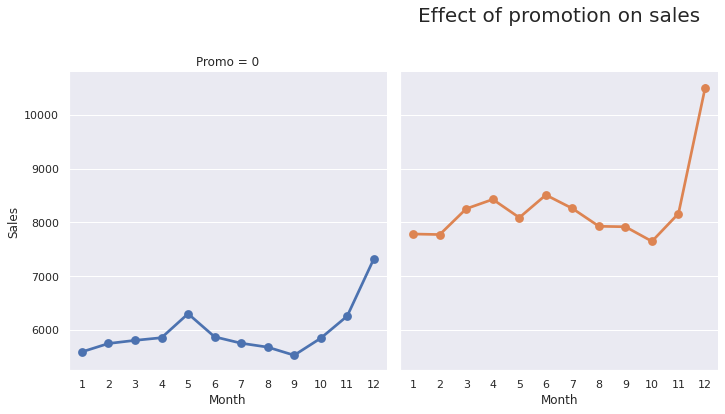

In [60]:
#promo and sales
sns.factorplot(data = train_store, x = 'Month', y = "Sales",hue = 'Promo',col = 'Promo') 
plt.title(f'Effect of promotion on sales\n\n ', size=20)

Text(0.5, 1.0, 'Effect of promotion on number of customers\n\n ')

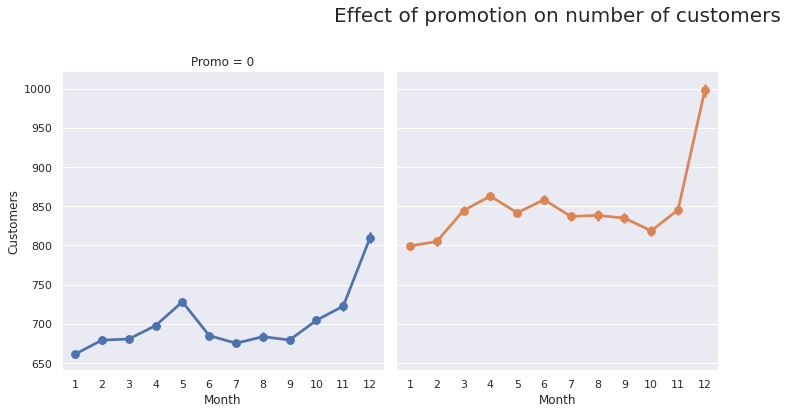

In [61]:
#promo and customers
sns.factorplot(data = train_store, x = 'Month', y = "Customers",hue = 'Promo',col = 'Promo')
plt.title(f'Effect of promotion on number of customers\n\n ', size=20)

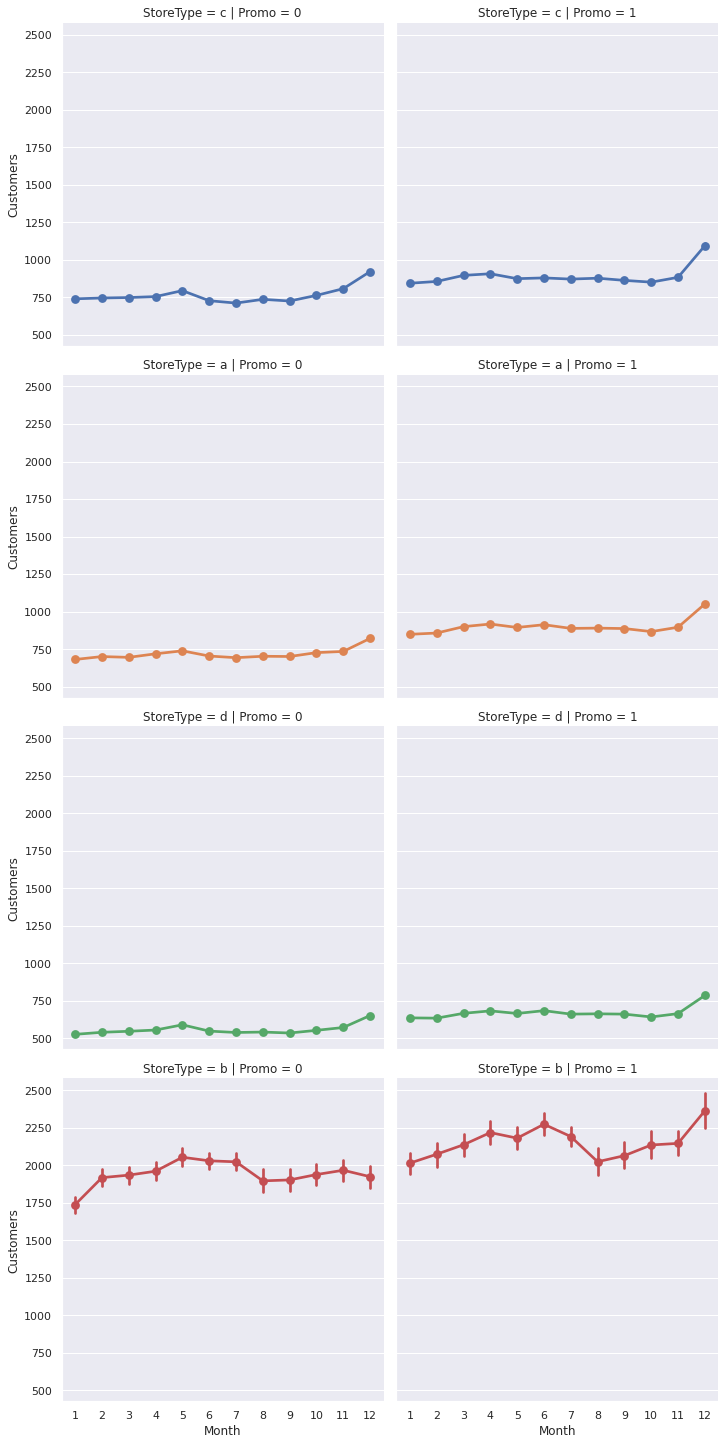

In [46]:
#Could the promos be deployed in more effective ways? Which stores should promos be deployed in?
#customers trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'Promo', # per store type in cols
               hue = 'StoreType',
               row = 'StoreType', # per promo in the store in rows
               ) 

#### Effect of Distance to the next competitor on sales

In [47]:
comp_store = train_store.groupby("Store").agg({'CompetitionDistance':'max','Sales':'sum'})

<AxesSubplot:xlabel='CompetitionDistance', ylabel='Sales'>

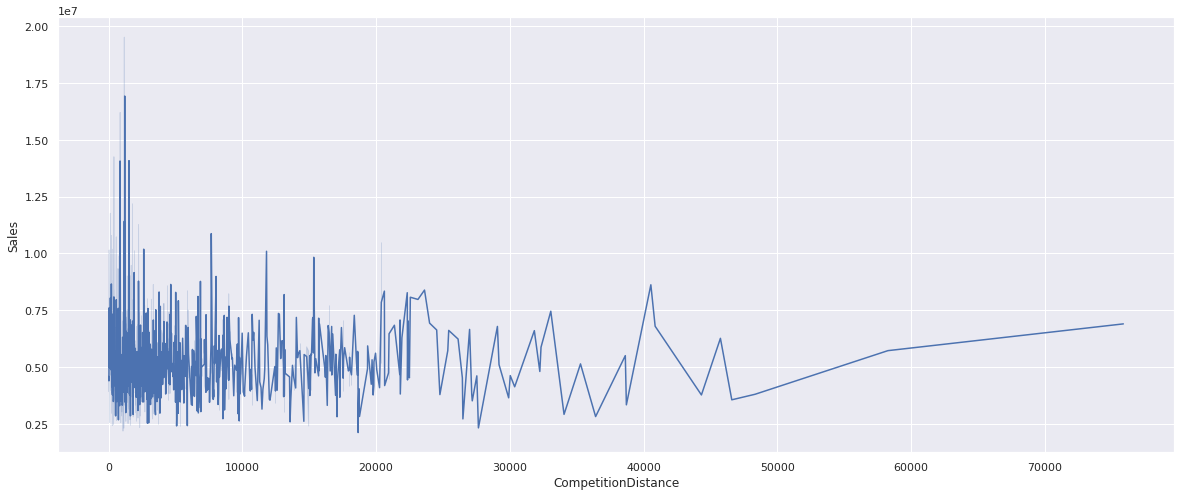

In [48]:
sns.lineplot(x = 'CompetitionDistance',y = "Sales",
             data = comp_store)

- The more stores that are in close proximity to each other, the more sales they make.
- This suggests that where other stores are within 10 kilometers, sales are higher.


In [63]:
# a function  to create and save logs in the log files
def log(path, file):
    """[Create a log file to record the experiment's logs]
    
    Arguments:
        path {string} -- path to the directory
        file {string} -- file name
    
    Returns:
        [obj] -- [logger that record logs]
    """

    # check if the file exist
    log_file = os.path.join(path, file)

    if not os.path.isfile(log_file):
        open(log_file, "w+").close()

    console_logging_format = "%(levelname)s %(message)s"
    file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"

    # configure logger
    logging.basicConfig(level=logging.INFO, format=console_logging_format)
    logger = logging.getLogger()
    
    # create a file handler for output file
    handler = logging.FileHandler(log_file)

    # set the logging level for log file
    handler.setLevel(logging.INFO)
    
    # create a logging format
    formatter = logging.Formatter(file_logging_format)
    handler.setFormatter(formatter)

    # add the handlers to the logger
    logger.addHandler(handler)

    return logger
